# Tutorial for `MDRefine` - 1c

In these notebooks we are going to perform several different refinements of MD-generated trajectories by employing the package `MDRefine`. In this way, we believe the usage of `MDRefine` will become clear and easy to emulate for your own case of interest.

We remind you to have a look at our paper https://arxiv.org/pdf/2411.07798 and at the documentation https://www.bussilab.org/doc-MDRefine/MDRefine/index.html.

Required assistance may be opened at https://github.com/bussilab/MDRefine/issues.

In [1]:
import numpy as np
import jax.numpy as jnp
import pandas
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
# import from parent directory
import sys
sys.path.insert(0, '../')

import MDRefine

print("I will use the MDRefine version installed at", MDRefine.__file__)

I will use the MDRefine version installed at ../MDRefine/__init__.py


In [3]:
from MDRefine import load_data, minimizer, hyper_minimizer, MDRefinement, unwrap_dict

## 3. Force-field refinement - alchemical calculations

Fitting of a force-field correction term for methylated adenosine by comparison of alchemical calculations from MD with $\Delta \Delta G$ measured in denaturation experiments.

Firstly, reproduce results from *V. Piomponi, et al. "Molecular simulations matching denaturation experiments for N6-methyladenosine" ACS Central Science 8.8 (2022): 1218-1228* https://pubs.acs.org/doi/full/10.1021/acscentsci.2c00565 for the refinements with $L^2$ regularization.

Then, perform a different regularization (with relative entropy) and compare it with the previous results from $L^2$ regularization.

In [4]:
%%bash

if [ ! -d "DATA_alchemical" ]; then
    curl -O https://zenodo.org/records/14956459/files/DATA_alchemical.zip

    unzip DATA_alchemical.zip
    rm -r DATA_alchemical.zip
fi

### a. Load data

For alchemical calculations, we have both `system_names` (names of each molecular system) and `cycle_names` (names of the thermodynamic cycles).

Each cycle is composed by 4 systems; `system_names` with corresponding thermodynamic cycle is defined as `'cycle_name' + '_' + s for s in ['AS','AD','MS','MD']` (A for adenosine, M for methylated; S for single, D for double strand).

The experimental DG is between (AS, AD) and (MS, MD), the simulated one is between (AS, MS) and (AD, MD).

In [30]:
infos = {}

infos['global'] = {}
infos['global']['temperature'] = 2.476
infos['global']['path_directory'] = 'DATA_alchemical'

# names of the thermodynamic cyles and associated molecular systems, in the correct order

cycle_names = ['A1', 'A2', 'A3', 'A4', 'A5']  # ,'B1','B2','B3','B4','B5']

names = {}
for name in cycle_names:
    names[name] = []
    for string in ['AS','AD','MS','MD']:
        names[name].append((name + '_' + string))

infos['global']['cycle_names'] = names
infos['global']['system_names'] = [s2 for s in list(names.values()) for s2 in s]

# force-field correction terms

n_charges = 5

infos['global']['names_ff_pars'] = ['DQ %i' % (i+1) for i in range(n_charges)] + ['cos eta']

columns = []
for i in range(n_charges):
    columns.append('DQ %i' % (i+1))
    columns.append('DQ %i%i' % (i+1,i+1))
for i in range(n_charges):
    for j in range(i+1,n_charges):
        columns.append('DQ %i%i' % (i+1,j+1))
columns.append('cos eta')

# only methylated (M) systems have a force-field correction

for name in infos['global']['system_names']: infos[name] = {}

for name in infos['global']['cycle_names'].keys():
    for s in ['D','S']:
        infos[name + '_M' + s]['ff_terms'] = columns

Define the force-field correction as

\begin{equation}
\Delta U(x) = \sum_{i=1}^5 K_i(x) \Delta Q_i + \sum_{i=1}^5 \sum_{j=i}^5 K_{ij}(x) \Delta Q_i \Delta Q_j - V_\eta \cos\eta_6(x);
\end{equation}

- use `jax.numpy` rather than `numpy` in order to do automatic differentiation;
- the force-field coefficients $\phi$ are: `['DQ %i' for i in range(n_charges)] + ['cos eta']`
- the columns of the force-field correction are

`['DQ 1', 'DQ 11', 'DQ 2', 'DQ 22', 'DQ 3', 'DQ 33', 'DQ 4', 'DQ 44', 'DQ 5', 'DQ 55', 'DQ 12', 'DQ 13', 'DQ 14', 'DQ 15', 'DQ 23', 'DQ 24', 'DQ 25', 'DQ 34', 'DQ 35', 'DQ 45', 'cos eta']`

where 2 numbers (such as `DQ 11` or `DQ 23`) mean the product `DQ 1 * DQ 1` or `DQ 2 * DQ 3`.

These charges correspond to: (Q1: N6; Q2: H61; Q3: N1; Q4: C10; Q5: H101/2/3)

In [31]:
names_charges = ['N6', 'H61', 'N1', 'C10', 'H101/2/3']

In [32]:
def ff_correction(phi, ff_terms):

    n_charges = 5

    phi_vector = []
    for i in range(n_charges):
        phi_vector.extend([phi[i], phi[i]**2])
    for i in range(n_charges):
        for j in range(i+1,n_charges):
            phi_vector.append(phi[i]*phi[j])
    phi_vector.append(-phi[-1])
    phi_vector = jnp.array(phi_vector)

    correction = jnp.matmul(ff_terms, phi_vector)

    return correction

In [33]:
for k in infos['global']['system_names']:
    if k[-2] == 'M': infos[k]['ff_correction'] = ff_correction

Once we have specified all the required information in `infos`, we can load the data from our directories with `load_data`.

In [34]:
data = load_data(infos)

loading data from directory...
loading  A1_AS
loading  A1_AD
loading  A1_MS
loading  A1_MD
loading  A2_AS
loading  A2_AD
loading  A2_MS
loading  A2_MD
loading  A3_AS
loading  A3_AD
loading  A3_MS
loading  A3_MD
loading  A4_AS
loading  A4_AD
loading  A4_MS
loading  A4_MD
loading  A5_AS
loading  A5_AD
loading  A5_MS
loading  A5_MD
done


In order to avoid numerical issues, put to zero the force-field correction terms corresponding to zero original weights (frames with zero weight will always have zero weight).

In [38]:
for s in data.properties.system_names:
    if hasattr(data.mol[s], 'f'):
        
        wh = np.argwhere(data.mol[s].weights == 0).flatten()

        try: data.mol[s].f[wh] = 0
        except: data.mol[s].f.at[wh].set(0)

In *V. Piomponi et al., https://pubs.acs.org/doi/full/10.1021/acscentsci.2c00565*, experimental uncertainties have value = 1

In [11]:
for s in data.properties.cycle_names:
    data.cycle[s].gexp_DDG[1] = 1

### b. Minimize the loss function and analyse the results - scan over $\beta$

In [12]:
from joblib import Parallel, delayed

#### L2 regularization

Define the regularization term. Rather than `'plain l2'`, we now have a constraint due to the requirement $\sum_{i=0}^5 \Delta Q_i + 2\Delta Q_4 = 0$ (total charge to be constant, with 3 $Q_4$ charges), so we have defined `'constraint 1'` as regularization in `MDRefine`:

\begin{equation}
\sum_{i=0}^4 \Delta Q_i^2 + \Delta Q_5^2 = \sum_{i=0}^4 \Delta Q_i^2 + \Bigl(\sum_{i=0}^4 \Delta Q_i + 2 \Delta Q_4\Bigr)^2.
\end{equation}

No regularization is added on $V_\eta$ parameter.

In [13]:
regularization = {'force_field_reg': 'constraint 1'}

It can also be defined by the user

In [14]:
def my_ff_reg(pars):
    lossf_reg = jnp.sum(pars[:-1]**2) + (np.sum(pars[:-1]) + 2*pars[4])**2  # + pars[-1]**2
    return lossf_reg

regularization = {'force_field_reg': my_ff_reg}

Then, let's perform a scan over different values of the hyperparameter $\beta$ (in logarithmic scale). In the paper we used 14 + 50 values, here you can also select fewer values to quickly get an overview of the results.

In [15]:
betas = np.array([0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 10000])

log10_betas = np.linspace(-1, 5, 20)
betas = np.unique(np.sort(np.concatenate((betas, 10**log10_betas))))

Let's look firstly at the $\chi^2$ for the original ensembles from MD

In [16]:
res = minimizer(data, regularization=regularization, beta=np.inf)

res.chi2

all the hyperparameters are infinite


{'A1': 21.06397979742576,
 'A2': 0.368626108813756,
 'A3': 12.38209101979724,
 'A4': 0.02181011054578029,
 'A5': 0.6429245282261995}

The following cell is to perform the scan without the parallelization (slower)

Let's run the cross validation with parallelization (faster)

In [17]:
Results_l2 = Parallel(n_jobs=5, verbose=1)(delayed(minimizer)(
        data, regularization=regularization, beta=beta) for beta in betas)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


KeyboardInterrupt: 

In [ ]:
vars(Results_l2[0]).keys()


dict_keys(['loss', 'pars', 'mini', 'intermediates', 'time', 'reg_ff', 'av_g', 'chi2', 'weights_new', 'logZ_new'])

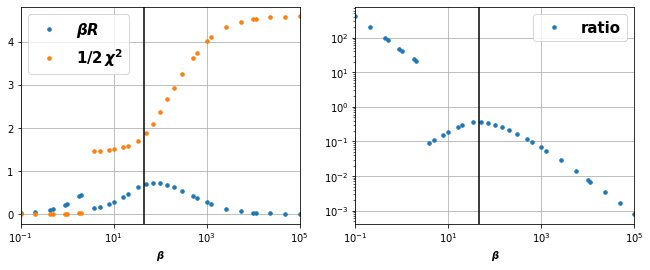

In [ ]:
betaR = [betas[i]*Results_l2[i].reg_ff for i in range(len(betas))]
chi2 = np.array([np.sum(list(Results_l2[i].chi2.values())) for i in range(len(betas))])
log_ratio = np.array(betaR)*2/chi2

fig, axs = plt.subplots(1, 2, figsize=(11, 4))

font = {'weight' : 'bold', 'size' : 15}

matplotlib.rc('font', **font)
matplotlib.rcParams['lines.markersize'] = 7

opt_beta = 45

axs[0].plot(betas, betaR, '.', label=r'$\beta R$')
axs[0].plot(betas, 1/2*chi2, '.', label=r'$1/2 \, \chi^2$')
# plt.plot(betas, [Results_l2[i].chi2 for i in range(len(betas))])

axs[1].plot(betas, log_ratio, '.', label='ratio')

axs[1].set_yscale('log')

for i in range(2):
    axs[i].set_xscale('log')
    axs[i].grid()
    axs[i].set_xlabel(r'$\beta$')
    axs[i].set_xlim([1e-1, 1e5])
    axs[i].legend()

    ylims = axs[i].get_ylim()
    axs[i].plot([opt_beta, opt_beta], [ylims[0], ylims[1]], '-k')
    axs[i].set_ylim(ylims)

# plt.savefig('../../Figures/alchemical_dkl_compare.pdf', format='pdf', bbox_inches='tight')

Now, plot both the correction coefficients (charges and $V_\eta$) and the deviation from the original ensembles (which can be measured by the Kish size, the relative entropy or the L2 regularization itself).

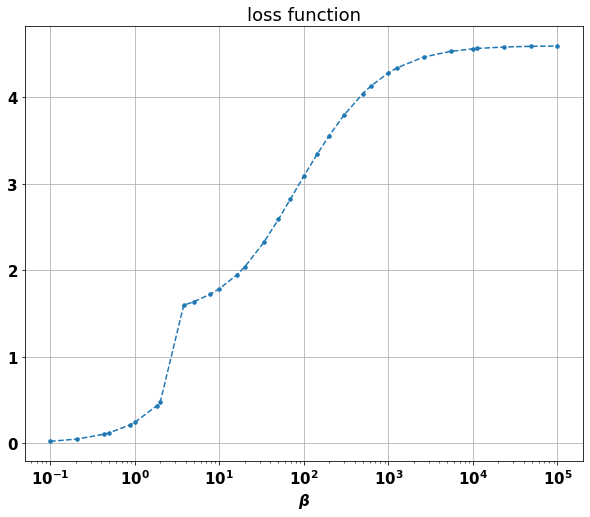

In [ ]:
loss = [Results_l2[i].loss for i in range(len(Results_l2))]

plt.figure(figsize=(10, 8))
plt.plot(betas, loss, '.--')
plt.xscale('log')
plt.title('loss function')
plt.xlabel(r'$\beta$')
plt.grid()
plt.show()

# plt.savefig('../../Figures/alchemical_L2_loss.png')

(0.1, 100000.0)

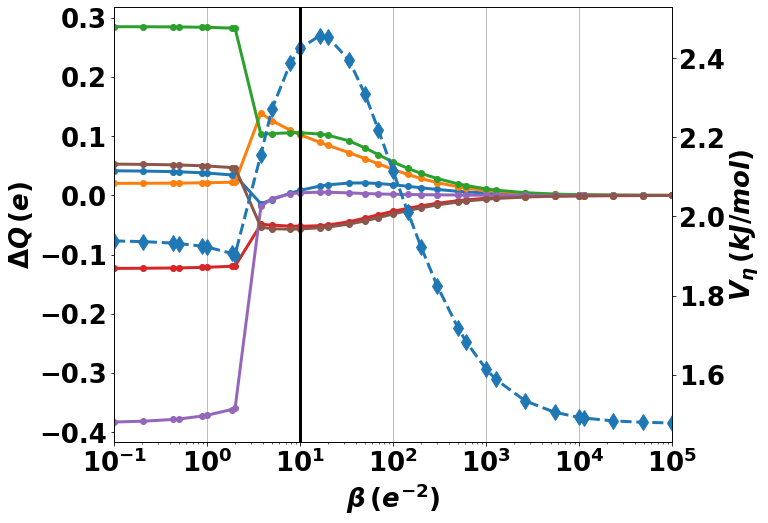

In [ ]:
font = {'weight' : 'bold', 'size' : 26}

matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 3
matplotlib.rcParams['lines.markersize'] = 12

fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()

# due to the constraint: total charge = 0
C6_charges = [(-np.sum(Results_l2[i].pars[:-1]) - 2*Results_l2[i].pars[-2]) for i in range(len(Results_l2))]
ax1.plot(betas, C6_charges, '.-', label='C6')

for j in range(len(names_charges)):
    ax1.plot(betas, [Results_l2[i].pars[j] for i in range(len(Results_l2))], '.-', label=names_charges[j])

ax2.plot(betas, [Results_l2[i].pars[-1] for i in range(len(Results_l2))], 'd--', label='$V_\eta$')

ax1.set_xscale('log')
ax1.set_xlabel(r'$\beta \, (e^{-2})$')
ax1.grid(axis='x')

ax1.set_ylabel('$\Delta Q \, (e)$')
ax2.set_ylabel('$V_\eta \, (kJ/mol)$')

# ax1.set_ylim([-0.45, 0.35])

ax2.plot([10, 10], [1.35, 2.53], '-k')
ax2.set_ylim([1.43, 2.53])
plt.xlim([1e-1, 1e5])

# ax1.legend(loc='lower right', fontsize=21, bbox_to_anchor=(1, 0.1))
# ax2.legend(loc='upper right', fontsize=21)

# plt.savefig('../../Figures/alchemical_L2_pars_big3.pdf', format='pdf', bbox_inches='tight')

In [ ]:
# pandas DataFrame for the coefficients

vec = np.array([Results_l2[i].pars for i in range(len(Results_l2))])

df_coeffs_L2 = pandas.DataFrame(vec[:,:-1], columns=[n + ' (e)' for n in names_charges])
df_coeffs_L2['C6 (e)'] = C6_charges
df_coeffs_L2[r'$V_\eta (kJ/mol)$'] = vec[:, -1]
df_coeffs_L2.index = betas

# df_coeffs_L2.to_csv('Results/alchemical_calculations/coefficients_L2charges')

Let's compute and plot the **Kish ratio**, namely, the ratio between the Kish sizes of the ensembles with original and optimized force field, respectively (for methylated systems).

In [ ]:
names = []

for name_sys in data.properties.system_names:
    if name_sys[-2] == 'M':
        names.append(name_sys)

kish_ratios = {}

for name_sys in names:
    kish_ratios[name_sys] = []
    for i in range(len(Results_l2)):
        ratio = np.sum(data.mol[name_sys].weights**2)/np.sum(Results_l2[i].weights_new[name_sys]**2)
        kish_ratios[name_sys].append(ratio)

# average values
kish_ratios['average'] = []

for i in range(len(Results_l2)):
    kish_ratios['average'].append(np.mean([kish_ratios[name_sys][i] for name_sys in names]))

And also the Kish sizes.

In [ ]:
kish_sizes = {}

for name_sys in names:
    kish_sizes[name_sys] = []
    for i in range(len(Results_l2)):
        kish_sizes[name_sys].append(np.sum(Results_l2[i].weights_new[name_sys]**2))

# average values
kish_sizes['average'] = []

for i in range(len(Results_l2)):
    kish_sizes['average'].append(np.mean([kish_sizes[name_sys][i] for name_sys in names]))

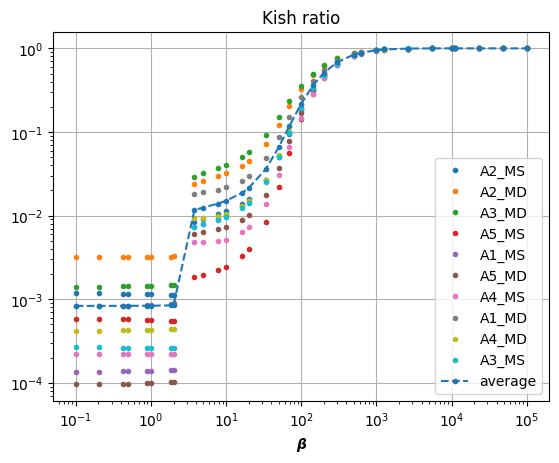

In [ ]:
matplotlib.rcdefaults()

for name in set(kish_ratios.keys())-set(['average']):
    plt.plot(betas, kish_ratios[name], '.', label=name)

plt.plot(betas, kish_ratios['average'], '.--', label='average')

plt.xscale('log')
plt.title('Kish ratio')
plt.xlabel(r'$\beta$')
plt.legend()
plt.yscale('log')
plt.grid()
plt.show()

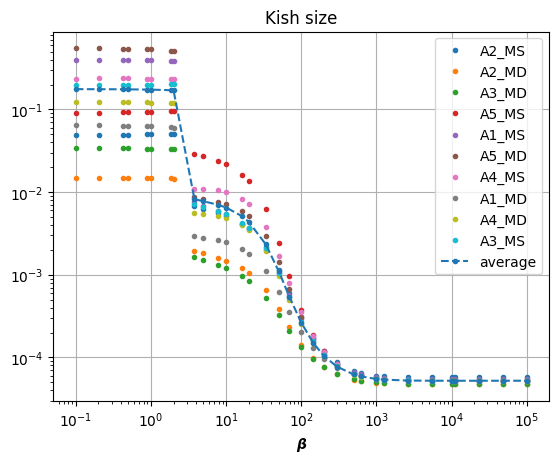

In [ ]:
matplotlib.rcdefaults()

for name in set(kish_sizes.keys())-set(['average']):
    plt.plot(betas, kish_sizes[name], '.', label=name)

plt.plot(betas, kish_sizes['average'], '.--', label='average')

plt.xscale('log')
plt.title('Kish size')
plt.xlabel(r'$\beta$')
plt.legend()
plt.yscale('log')
plt.grid()
plt.show()

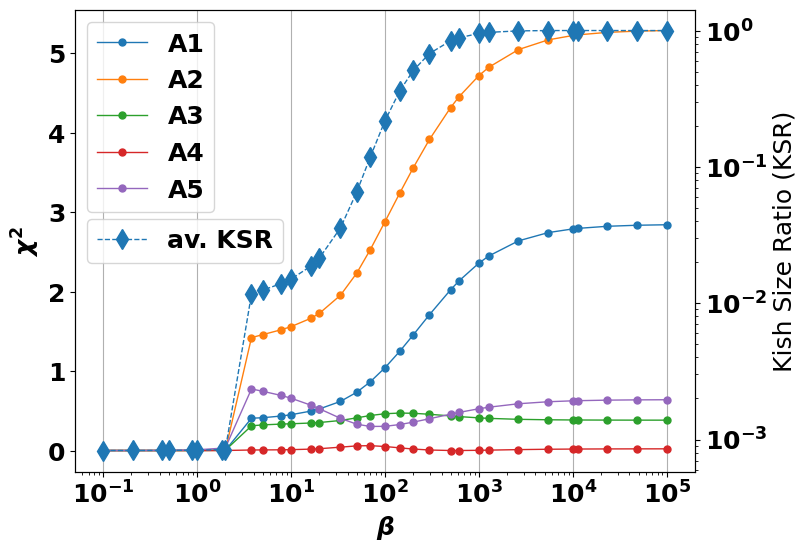

In [ ]:
font = {'weight' : 'bold', 'size' : 18}

matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 10

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

chi2s = {}
for cycle_name in data.properties.cycle_names:
    chi2s[cycle_name] = [Results_l2[i].chi2[cycle_name] for i in range(len(Results_l2))]
    ax1.plot(betas, chi2s[cycle_name], '.-', label=cycle_name)

ax2.plot(betas, kish_ratios['average'], 'd--', label='av. KSR')

ax1.set_xscale('log')
ax1.set_xlabel(r'$\beta$')
ax1.grid(axis='x')

ax1.set_ylabel('$\chi^2$')
ax2.set_ylabel('Kish Size Ratio (KSR)')
ax2.set_yscale('log')

# ax1.set_ylim('low': 0)#[-0.45, 0.35])
# ax2.set_ylim([1.4, 2.5])

ax1.legend()#loc='upper right')
ax2.legend(loc='center left')

# plt.title('$\Delta Q$ parameters')
# plt.xlabel('$\beta$')
# plt.legend()
# plt.grid()
plt.show()

# plt.savefig('../../Figures/alchemical_L2_Kish_chi2.png')

Here, plot the $\chi^2$ as a function of $\beta$

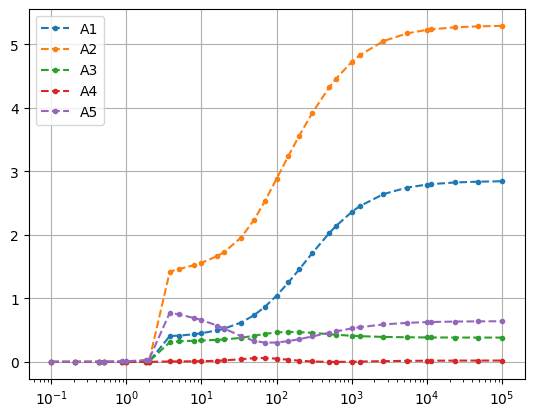

In [ ]:
matplotlib.rcdefaults()

chi2s = {}

for cycle_name in data.properties.cycle_names:
    chi2s[cycle_name] = [Results_l2[i].chi2[cycle_name] for i in range(len(Results_l2))]
    plt.plot(betas, chi2s[cycle_name], '.--', label=cycle_name)

plt.xscale('log')
plt.legend()
plt.grid()

Make a pandas DataFrame `df` with Kish ratios and $\chi^2$

In [ ]:
arr = np.vstack((np.array(loss), kish_ratios['average'], [chi2s[cycle_name] for cycle_name in data.properties.cycle_names])).T
df_L2 = pandas.DataFrame(arr)
df_L2.columns = ['loss', 'kish ratio'] + ['chi2s ' + name for name in data.properties.cycle_names]
df_L2.index = betas

# df_L2.to_csv('Results/alchemical_calculations/values_L2charges')

#### relative entropy regularization

Now, repeat the same analysis with a different regularization term, given by (minus) the relative entropy (`'KL divergence'`) rather than an $L^2$ regularization. Then, compare the two results

In [ ]:
regularization = {'force_field_reg': 'KL divergence'}

In [ ]:
betas = [2e-2, 5e-2, 0.1, 0.5, 1, 5, 10, 100, 1e3, 1e4, 1e5, 1e6]

log10_betas = np.linspace(-3, 7, 20)
betas = np.unique(np.sort(np.concatenate((betas, 10**log10_betas))))

The following cell is to perform the scan without the parallelization (slower)

Let's run the cross validation with parallelization (faster)

In [ ]:
Results = Parallel(n_jobs=10, verbose=1)(delayed(minimizer)(
        data, regularization=regularization, beta=beta) for beta in betas)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


KeyboardInterrupt: 

Check convergence and make plots

In [ ]:
print([Results[i].mini.success for i in range(len(Results))])

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


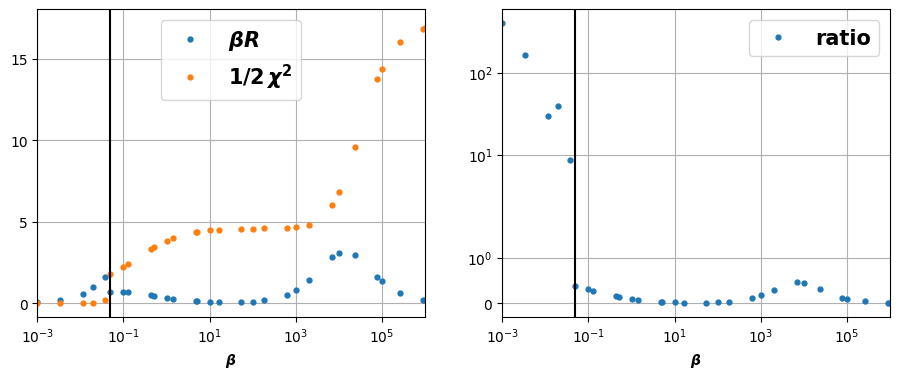

In [ ]:
betaR = [betas[i]*np.sum(list(Results[i].reg_ff.values())) for i in range(len(betas))]
chi2 = np.array([np.sum(list(Results[i].chi2.values())) for i in range(len(betas))])
log_ratio = np.array(betaR)*2/chi2

fig, axs = plt.subplots(1, 2, figsize=(11, 4))

font = {'weight' : 'bold', 'size' : 15}

matplotlib.rcdefaults()
matplotlib.rc('font', **font)
matplotlib.rcParams['lines.markersize'] = 7

opt_beta = 0.05

axs[0].plot(betas, betaR, '.', label=r'$\beta R$')
axs[0].plot(betas, 1/2*chi2, '.', label=r'$1/2 \, \chi^2$')
# plt.plot(betas, [Results_l2[i].chi2 for i in range(len(betas))])
# axs[0].plot([opt_beta, opt_beta], [0, 5], '-k')

axs[1].plot(betas, log_ratio, '.', label='ratio')

axs[1].set_yscale('symlog')

for i in range(2):
    axs[i].set_xscale('log')
    axs[i].grid()
    axs[i].set_xlabel(r'$\beta$')
    axs[i].set_xlim([1e-3, 1e6])
    axs[i].legend()

    ylims = axs[i].get_ylim()
    axs[i].plot([opt_beta, opt_beta], [ylims[0], ylims[1]], '-k')
    axs[i].set_ylim(ylims)

# plt.savefig('../../Figures/alchemical_dkl_compare.pdf', format='pdf', bbox_inches='tight')

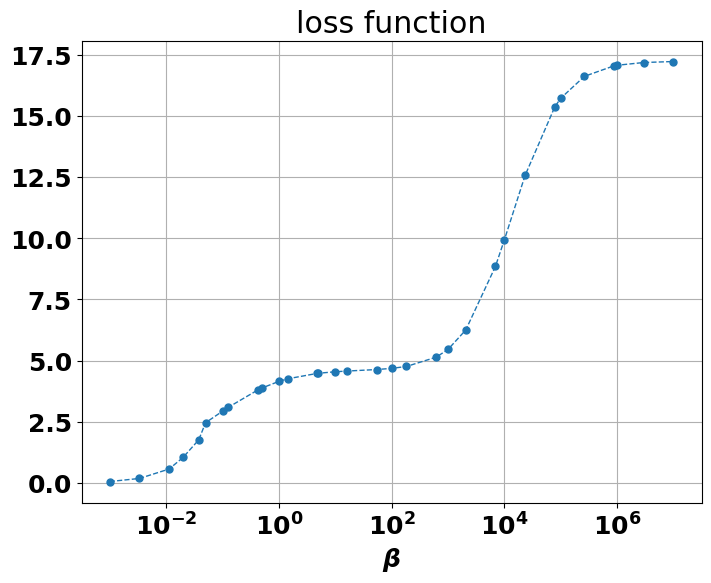

In [ ]:
loss = [Results[i].loss for i in range(len(betas))]

font = {'weight' : 'bold', 'size' : 18}

matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 10

plt.figure(figsize=(8, 6))

plt.plot(betas, loss, '.--')
plt.xscale('log')
plt.title('loss function')
plt.xlabel(r'$\beta$')
plt.grid()
# plt.show()

# plt.savefig('../../Figures/alchemical_DKL_loss.png')

(0.001, 10000000.0)

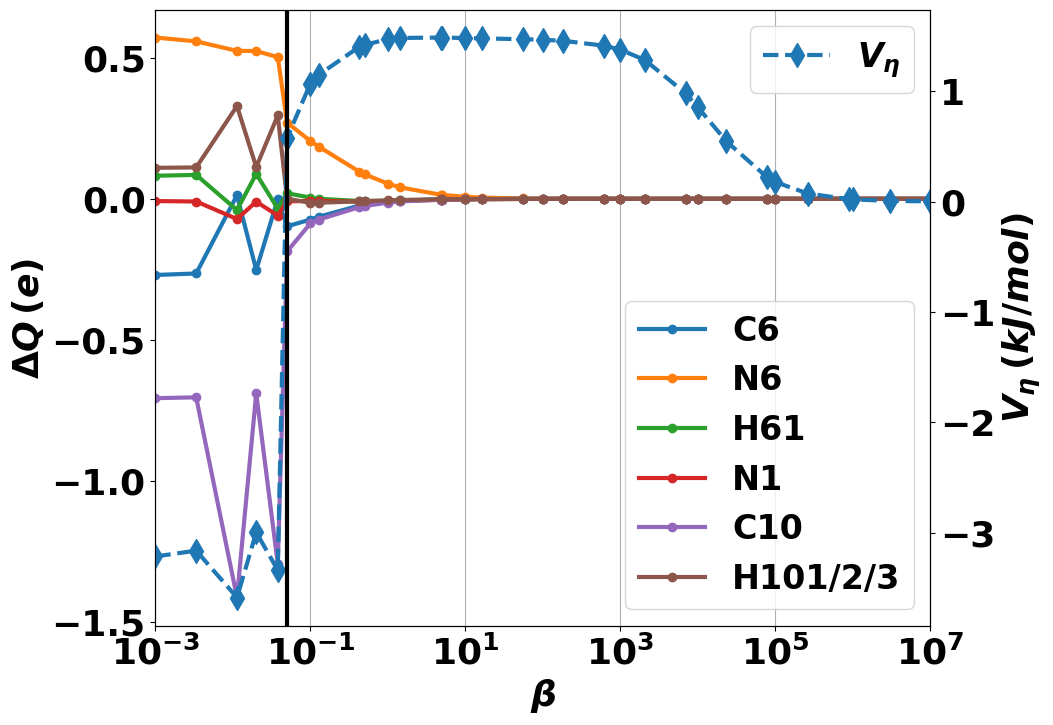

In [ ]:
font = {'weight' : 'bold', 'size' : 26}

matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 3
matplotlib.rcParams['lines.markersize'] = 12

fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()

# due to the constraint: total charge = 0
C6_charges = [(-np.sum(Results[i].pars[:-1]) - 2*Results[i].pars[-2]) for i in range(len(betas))]
ax1.plot(betas, C6_charges, '.-', label='C6')

for j in range(len(names_charges)):
    ax1.plot(betas, [Results[i].pars[j] for i in range(len(betas))], '.-', label=names_charges[j])

ax2.plot(betas, [Results[i].pars[-1] for i in range(len(betas))], 'd--', label='$V_\eta$')

ax1.set_xscale('log')
# ax1.set_yscale('symlog')
ax1.set_xlabel(r'$\beta$')
ax1.grid(axis='x')

ax1.set_ylabel('$\Delta Q \, (e)$')
ax2.set_ylabel('$V_\eta \, (kJ/mol)$')

# ax1.set_ylim([-0.45, 0.35])
# ax2.set_ylim([1.4, 2.5])

ax1.legend(loc='lower right', fontsize=24)
ax2.legend(loc='upper right', fontsize=24)

ylims = ax2.get_ylim()
ax2.plot([0.05, 0.05], ylims, '-k')
ax2.set_ylim(ylims)
# plt.title('$\Delta Q$ parameters')
# plt.xlabel('$\beta$')
# plt.legend()
# plt.grid()
# plt.show()
ax1.set_xlim([1e-3, 1e7])

# plt.savefig('../../Figures/alchemical_dkl_pars_big2.pdf', format='pdf', bbox_inches='tight')

Make pandas DataFrame `df_DKL` with force-field correction coefficients

In [ ]:
vec = np.array([Results[i].pars for i in range(len(Results))])

df_coeffs_DKL = pandas.DataFrame(vec[:,:-1], columns=[n + ' (e)' for n in names_charges])
df_coeffs_DKL['C6 (e)'] = C6_charges
df_coeffs_DKL[r'$V_\eta (kJ/mol)$'] = vec[:, -1]
df_coeffs_DKL.index = betas

# df_coeffs_DKL.to_csv('Results/alchemical_calculations/coefficients_DKL')

Compute Kish ratios and Kish sample sizes

In [ ]:
names = []

for name_sys in data.properties.system_names:
    if name_sys[-2] == 'M':
        names.append(name_sys)

kish_ratios = {}

for name_sys in names:
    kish_ratios[name_sys] = []
    for i in range(len(betas)):
        ratio = np.sum(data.mol[name_sys].weights**2)/np.sum(Results[i].weights_new[name_sys]**2)
        kish_ratios[name_sys].append(ratio)

In [ ]:
kish_ratios['average'] = []

for i in range(len(Results)):
    kish_ratios['average'].append(np.mean([kish_ratios[name_sys][i] for name_sys in names]))

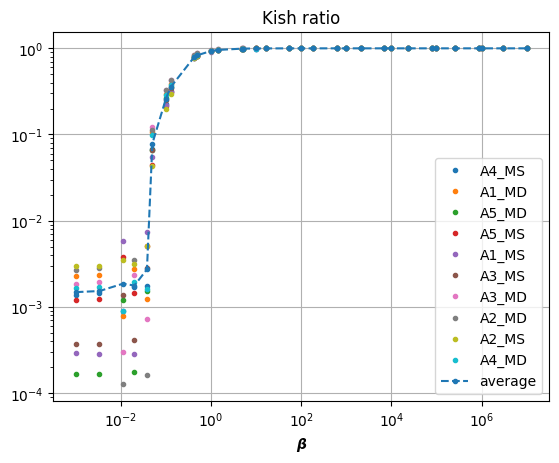

In [ ]:
matplotlib.rcdefaults()

for name in set(kish_ratios.keys()) - set(['average']):
    plt.plot(betas, kish_ratios[name], '.', label=name)

plt.plot(betas, kish_ratios['average'], '.--', label='average')

plt.xscale('log')
plt.title('Kish ratio')
plt.xlabel(r'$\beta$')
plt.legend()
plt.yscale('log')
plt.grid()
plt.show()

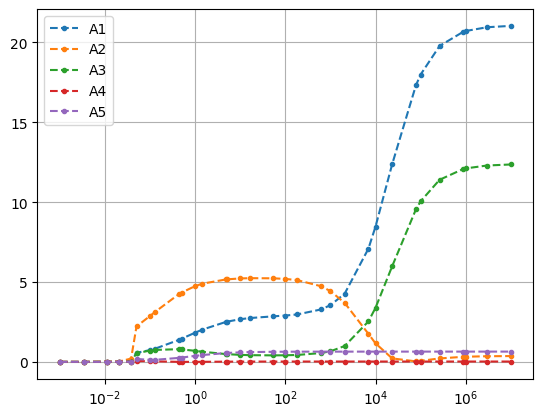

In [ ]:
# plot chi2
chi2s = {}

for cycle_name in data.properties.cycle_names:
    chi2s[cycle_name] = [Results[i].chi2[cycle_name] for i in range(len(Results))]
    plt.plot(betas, chi2s[cycle_name], '.--', label=cycle_name)

plt.xscale('log')
plt.legend()
plt.grid()

Add to `df_DKL` DataFrame Kish ratios and $\chi^2$

In [ ]:
arr = np.vstack((np.array(loss), kish_ratios['average'], [chi2s[cycle_name] for cycle_name in data.properties.cycle_names])).T
df_DKL = pandas.DataFrame(arr)
df_DKL.columns = ['loss', 'kish ratio'] + ['chi2s ' + name for name in data.properties.cycle_names]
df_DKL.index = betas

# df_DKL.to_csv('Results/alchemical_calculations/values_DKL')

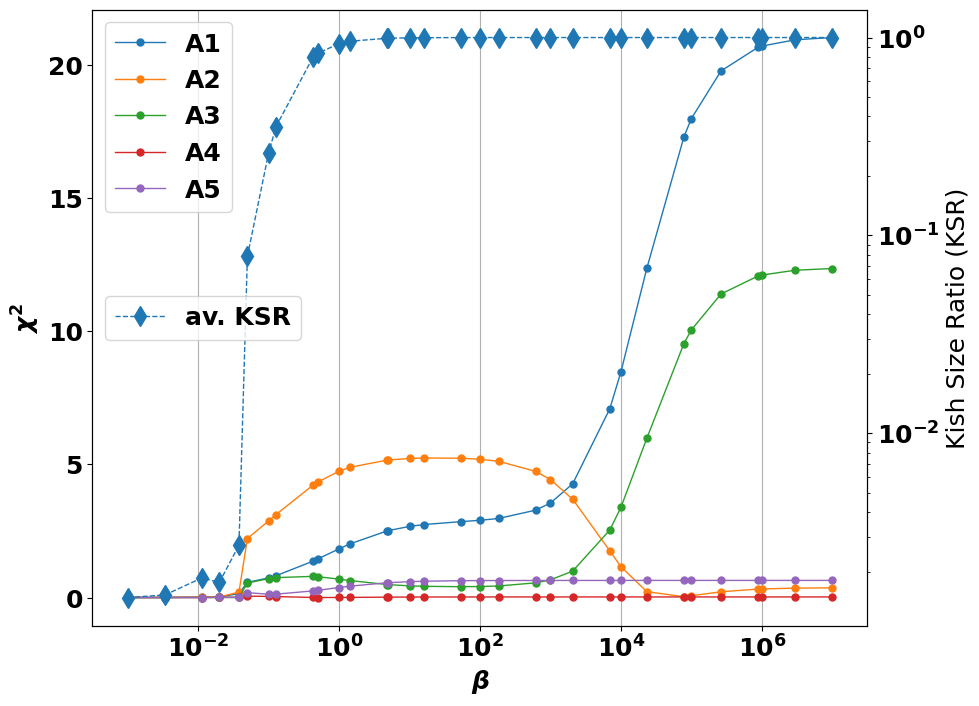

In [ ]:
font = {'weight' : 'bold', 'size' : 18}

matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 10

fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()

for cycle_name in data.properties.cycle_names:
    chi2s = [Results[i].chi2[cycle_name] for i in range(len(betas))]
    ax1.plot(betas, chi2s, '.-', label=cycle_name)

ax2.plot(betas, kish_ratios['average'], 'd--', label='av. KSR')

ax1.set_xscale('log')
ax1.set_xlabel(r'$\beta$')
ax1.grid(axis='x')

ax1.set_ylabel('$\chi^2$')
ax2.set_ylabel('Kish Size Ratio (KSR)')
ax2.set_yscale('log')

# ax1.set_ylim('low': 0)#[-0.45, 0.35])
# ax2.set_ylim([1.4, 2.5])

ax1.legend()#loc='upper right')
ax2.legend(loc='center left')

# plt.title('$\Delta Q$ parameters')
# plt.xlabel('$\beta$')
# plt.legend()
# plt.grid()
# plt.show()

# plt.savefig('../../Figures/alchemical_DKL_Kish_chi2.png')

### c. Analyse data from previous calculations

Now, let's compare the results with $L^2$ and $D_{KL}$ regularizations

In [ ]:
# df_L2 = pandas.read_csv('Results/alchemical_calculations/values_L2charges', index_col=0)
# df_DKL = pandas.read_csv('Results/alchemical_calculations/values_DKL', index_col=0)

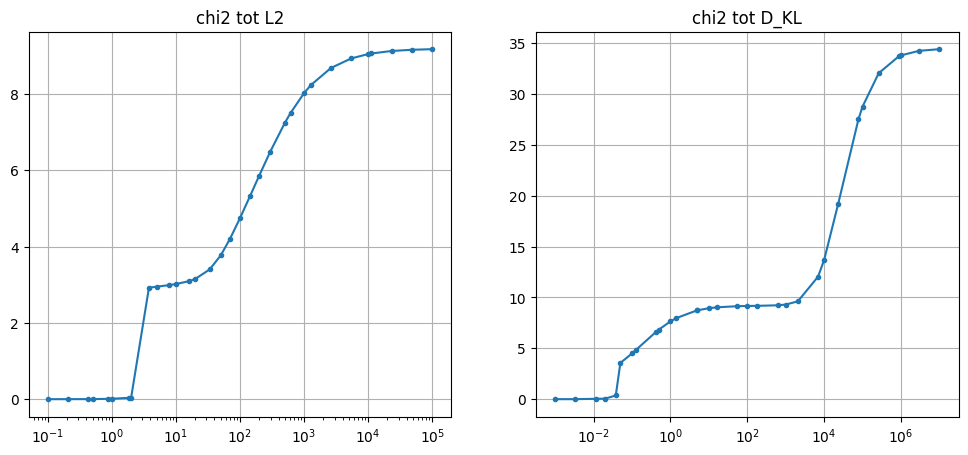

In [ ]:
plt.rcdefaults()

my_list = [s for s in df_L2.columns if s.startswith('chi2s')]
df_L2['chi2 tot'] = np.sum(np.array(df_L2[my_list]), axis=1)

my_list = [s for s in df_DKL.columns if s.startswith('chi2s')]
df_DKL['chi2 tot'] = np.sum(np.array(df_DKL[my_list]), axis=1)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(df_L2['chi2 tot'], '.-')
axs[0].set_xscale('log')
axs[0].set_title('chi2 tot L2')
axs[0].grid()

axs[1].plot(df_DKL['chi2 tot'], '.-')
axs[1].set_xscale('log')
axs[1].set_title('chi2 tot D_KL')
axs[1].grid()

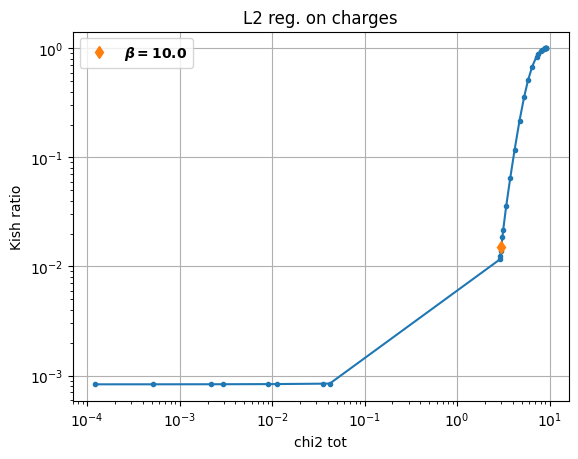

In [ ]:
plt.plot(df_L2['chi2 tot'], df_L2['kish ratio'], '.-')

diff = np.abs(df_L2.index - 10)
opt_beta = df_L2.index[diff == np.min(diff)][0]
# the closest scanned value to 10

plt.plot(df_L2['chi2 tot'][opt_beta], df_L2['kish ratio'][opt_beta], 'd', label=r'$\beta=%.1f$' % opt_beta)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.title('L2 reg. on charges')
plt.xlabel('chi2 tot')
plt.ylabel('Kish ratio')
plt.legend()
# plt.savefig('../../Figures/alchemical_L2charges_kish_vs_chi2.png')

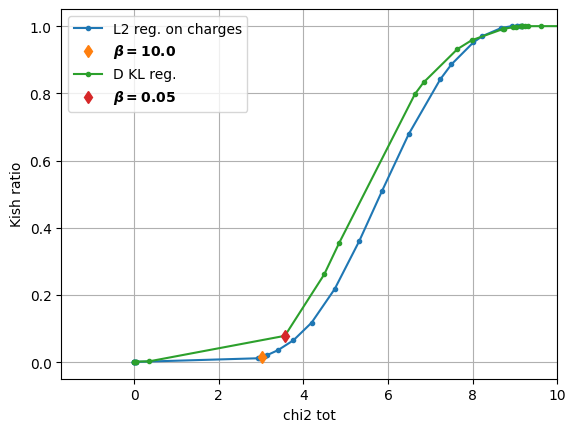

In [ ]:
plt.plot(df_L2['chi2 tot'], df_L2['kish ratio'], '.-', label='L2 reg. on charges')

diff = np.abs(df_L2.index - 10)
opt_beta = df_L2.index[diff == np.min(diff)][0]
# the closest scanned value to 10

plt.plot(df_L2['chi2 tot'][opt_beta], df_L2['kish ratio'][opt_beta], 'd', label=r'$\beta=%.1f$' % opt_beta)

plt.plot(df_DKL['chi2 tot'], df_DKL['kish ratio'], '.-', label='D KL reg.')

diff = np.abs(df_DKL.index - 0.05)
opt_beta = df_DKL.index[diff == np.min(diff)][0]
# the closest scanned value to 0.05

plt.plot(df_DKL['chi2 tot'][opt_beta], df_DKL['kish ratio'][opt_beta], 'd', label=r'$\beta=%.2f$' % opt_beta)

# plt.xscale('log')
# plt.yscale('log')
plt.grid()
# plt.title('relative entropy reg.')
plt.xlabel('chi2 tot')
plt.ylabel('Kish ratio')
plt.xlim(right=10)
plt.legend()
# plt.savefig('../../Figures/alchemical_DKL_kish_vs_chi2.png')
# plt.savefig('../../Figures/alchemical_kish_vs_chi2_linear_upxlimit.png')

#### Compute and plot the relative Kish size vs. the total $\chi^2$
In this way, you compare an estimate for the discrepancy from the original ensemble with an estimate for the distance from the experimental values in both the two cases ($L^2$ and $D_{KL}$ regularization) along the scan on $\beta$ values.


The (relative) Kish size is defined as ${\langle \frac{w}{w_0} \rangle_w}^{-1} = 1/\sum_x \frac{w(x)^2}{w_0(x)}$.

The Kish ratio is defined as the ratio of the two Kish sample sizes $KSR = \frac{\langle w \rangle_w ^{-1}}{\langle w_0 \rangle_{w_0}^{-1}}$.

In [ ]:
from MDRefine import compute_new_weights, compute_D_KL

firstly, compute new weights from optimal coefficients

In [ ]:
# df_coeffs_L2 = pandas.read_csv('Results/alchemical_calculations/coefficients_L2charges', index_col=0)
# df_coeffs_DKL = pandas.read_csv('Results/alchemical_calculations/coefficients_DKL', index_col=0)

betas = df_coeffs_L2.index

weights_L2 = {}
kish_size_L2 = {}
kish_ratio_L2 = {}
rel_entropy_L2 = {}

for i, beta in enumerate(betas):
    coeffs_L2 = list(df_coeffs_L2.iloc[i, :5]) + [df_coeffs_L2.iloc[i, 6]]

    weights_L2[beta] = {}
    kish_size_L2[beta] = {}
    kish_ratio_L2[beta] = {}
    rel_entropy_L2[beta] = {}

    for sys_name in data.properties.system_names:
        if hasattr(data.mol[sys_name], 'f'):
            wh = np.argwhere(data.mol[sys_name].weights != 0)
            w0 = data.mol[sys_name].weights[wh]
            weights_L2[beta][sys_name] = compute_new_weights(data.mol[sys_name].weights, ff_correction(coeffs_L2, data.mol[sys_name].f)/data.mol[sys_name].temperature)[0][wh]

            kish_size_L2[beta][sys_name] = 1/np.sum(weights_L2[beta][sys_name]**2/w0)
            kish_ratio_L2[beta][sys_name] = np.sum(w0**2)/np.sum(weights_L2[beta][sys_name]**2)

            wh = np.argwhere(weights_L2[beta][sys_name] != 0)
            rel_entropy_L2[beta][sys_name] = np.sum(weights_L2[beta][sys_name][wh]*np.log(weights_L2[beta][sys_name][wh]/w0[wh]))

betas = df_coeffs_DKL.index

weights_DKL = {}
kish_size_DKL = {}
rel_entropy_DKL = {}
kish_ratio_DKL = {}

for i, beta in enumerate(betas):
    coeffs_DKL = list(df_coeffs_DKL.iloc[i, :5]) + [df_coeffs_DKL.iloc[i, 6]]
    
    weights_DKL[beta] = {}
    kish_size_DKL[beta] = {}
    kish_ratio_DKL[beta] = {}
    rel_entropy_DKL[beta] = {}

    for sys_name in data.properties.system_names:
        if hasattr(data.mol[sys_name], 'f'):
            wh = np.argwhere(data.mol[sys_name].weights != 0)
            w0 = data.mol[sys_name].weights[wh]
            weights_DKL[beta][sys_name] = compute_new_weights(data.mol[sys_name].weights, ff_correction(coeffs_DKL, data.mol[sys_name].f)/data.mol[sys_name].temperature)[0][wh]

            kish_size_DKL[beta][sys_name] = 1/np.sum(weights_DKL[beta][sys_name]**2/w0)
            kish_ratio_DKL[beta][sys_name] = np.sum(w0**2)/np.sum(weights_DKL[beta][sys_name]**2)

            wh = np.argwhere(weights_DKL[beta][sys_name] != 0)
            rel_entropy_DKL[beta][sys_name] = np.sum(weights_DKL[beta][sys_name][wh]*np.log(weights_DKL[beta][sys_name][wh]/w0[wh]))


add these values to the pandas DataFrames previously defined `df_L2` and `df_DKL`

In [ ]:
betas = list(kish_size_L2.keys())

sys_names = kish_size_L2[betas[0]].keys()

for sys_name in sys_names:
    df_L2['Kish size %s' % sys_name] = [kish_size_L2[beta][sys_name] for beta in betas]
    df_L2['D_KL %s' % sys_name] = [rel_entropy_L2[beta][sys_name] for beta in betas]

betas = list(kish_size_DKL.keys())

for sys_name in sys_names:
    df_DKL['Kish size %s' % sys_name] = [kish_size_DKL[beta][sys_name] for beta in betas]
    df_DKL['D_KL %s' % sys_name] = [rel_entropy_DKL[beta][sys_name] for beta in betas]

In [ ]:
sys_names = kish_size_DKL[beta].keys()

betas = kish_size_DKL.keys()
kish_size_tot_DKL = []
for beta in betas:
    kish_size_tot_DKL.append(np.sum([kish_size_DKL[beta][sys_name] for sys_name in sys_names]))

betas = kish_size_L2.keys()
kish_size_tot_L2 = []
for beta in betas:
    kish_size_tot_L2.append(np.sum([kish_size_L2[beta][sys_name] for sys_name in sys_names]))


df_L2['Kish size tot'] = kish_size_tot_L2
df_DKL['Kish size tot'] = kish_size_tot_DKL

In [ ]:
sys_names = [s[5:] for s in list(df_DKL.keys()) if s.startswith('D_KL ')]
sys_names = [s for s in sys_names if not s == 'tot']

sys_names

['A1_MS',
 'A1_MD',
 'A2_MS',
 'A2_MD',
 'A3_MS',
 'A3_MD',
 'A4_MS',
 'A4_MD',
 'A5_MS',
 'A5_MD']

Plot the inverse relative Kish size as a function of the total $\chi^2$. In this way, you can compare the refinements with the two regularization terms. You could also plot the total Kullback-Leibler divergence `s='D_KL tot'`, in this case you don't have to take the inverse in `plot`.

In [ ]:
df_DKL

,loss,kish ratio,chi2s A1,chi2s A2,chi2s A3,chi2s A4,chi2s A5,chi2 tot,Kish size A1_MS,D_KL A1_MS,...,D_KL A3_MD,Kish size A4_MS,D_KL A4_MS,Kish size A4_MD,D_KL A4_MD,Kish size A5_MS,D_KL A5_MS,Kish size A5_MD,D_KL A5_MD,Kish size tot
1.000000e-03,0.053460,0.001481,0.000010,0.000070,0.000027,0.000151,0.000007,0.000265,0.00025982236205734796,6.505809808127596,...,4.472219168468126,0.001383344704771453,5.117892456651371,0.0012500263319933306,4.974777291156685,0.0011637803935020746,5.515873264962524,0.0001971423167077668,7.015593926862655,0.013423
3.359818e-03,0.178740,0.001525,0.000187,0.000700,0.000164,0.000975,0.000124,0.002149,0.00025040559795117104,6.503930623076558,...,4.396674569072573,0.0014100721142970708,5.085043522399925,0.0012601527862814788,4.954475497923519,0.0012488782797038392,5.454582483257784,0.0001982797518163427,6.9907485560080636,0.014031
1.128838e-02,0.564033,0.001860,0.016396,0.019811,0.000171,0.000496,0.000010,0.036885,0.006241682290807471,3.5060209344516258,...,5.526205473551086,0.00032138411676887384,5.273392022376125,0.0004048335002339644,5.055886109788611,0.0012246995158645775,3.974945547756433,0.001156652760885889,4.398182608502048,0.014106
2.000000e-02,1.040350,0.001765,0.013672,0.021460,0.000881,0.006965,0.008658,0.051636,0.00025551609347416673,6.33983752538484,...,4.132373956089625,0.0016038495213803138,4.896359490940316,0.0014370863076508223,4.791315341057899,0.0015036772600197485,5.226693722944506,0.0002143574351075765,6.779751995374467,0.016617
3.792690e-02,1.759291,0.002724,0.148390,0.202575,0.004371,0.005310,0.002661,0.363308,0.007966659184754385,3.178814698363839,...,4.311997594749433,0.0006846501307393886,4.407378597409467,0.0006315015235725349,4.306361627335597,0.0033182841261398086,3.5200122891878673,0.0016533555242057964,3.9006293696127177,0.021833
5.000000e-02,2.455869,0.078483,0.568533,2.215856,0.545488,0.049747,0.182933,3.562556,0.05393806076141528,1.4809173287904729,...,1.0536713774923345,0.06865114413960068,1.4742093512629044,0.09201281981713594,1.3169062344331135,0.045078782130830206,1.5199113575471008,0.06569584456286609,1.3772572296266408,0.756190
1.000000e-01,2.926841,0.260983,0.738401,2.877295,0.708036,0.043712,0.124069,4.491513,0.223697385041473,0.7354191110370032,...,0.5429203833157147,0.22907534130953353,0.7443177818825564,0.273399010991216,0.6753503051011411,0.20909897525462923,0.7441470481966653,0.25623802025159936,0.6925815137475383,2.551051
1.274275e-01,3.090502,0.354863,0.819267,3.115961,0.747678,0.035660,0.127302,4.845868,0.3173604024509081,0.5635996300556962,...,0.41944325284003764,0.3182319525356459,0.5703036579283606,0.3629718200067164,0.5214391061501449,0.3057517565935868,0.5699478576865751,0.34712457191169616,0.5351247170388441,3.482287
4.281332e-01,3.802614,0.797431,1.366869,4.223340,0.794181,0.001938,0.248007,6.634336,0.7804460787461279,0.12406878608418603,...,0.08792727855456553,0.7809010948706839,0.12264401833218795,0.7949212574204949,0.11563932100413796,0.7788018780142996,0.12423230220895898,0.788381687775064,0.11926032356599559,7.971507
5.000000e-01,3.875654,0.832352,1.449649,4.337262,0.781220,0.000692,0.270678,6.839501,0.8186668160109649,0.10031709905927264,...,0.07004491566490681,0.8197548888292631,0.09874848630079994,0.8308446946804028,0.0933266779984467,0.8177350476145897,0.10012810756389828,0.8254246276430898,0.09626269188771867,8.334717


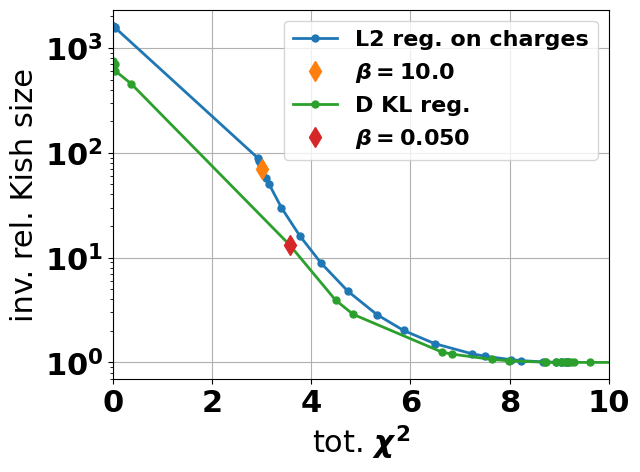

In [ ]:
font = {'weight' : 'bold', 'size' : 22}

matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['lines.markersize'] = 10

s = 'av. Kish size'
# s = 'av. D_KL'

if s[:4] == 'av. ':
    cols = ['%s %s' % (s[4:], sys_name) for sys_name in sys_names]
    df_L2[s] = np.mean(df_L2[cols], axis=1)
    df_DKL[s] = np.mean(df_DKL[cols], axis=1)

plt.plot(df_L2['chi2 tot'], 1/df_L2[s], '.-', label='L2 reg. on charges')

diff = np.abs(df_L2.index - 10)
opt_beta = df_L2.index[diff == np.min(diff)][0]
plt.plot(df_L2['chi2 tot'][opt_beta], 1/df_L2[s][opt_beta], 'd', label=r'$\beta=%.1f$' % opt_beta)

plt.plot(df_DKL['chi2 tot'], 1/df_DKL[s], '.-', label='D KL reg.')

diff = np.abs(df_DKL.index - 0.05)
opt_beta2 = df_DKL.index[diff == np.min(diff)][0]
plt.plot(df_DKL['chi2 tot'][opt_beta2], 1/df_DKL[s][opt_beta2], 'd', label=r'$\beta=%.3f$' % opt_beta2)

# plt.xscale('log')
plt.yscale('log')
plt.grid()
# plt.title('relative entropy reg.')
plt.xlabel('tot. $\chi^2$')
plt.ylabel('inv. rel. Kish size')
plt.xlim([0, 10])  # right=10)
plt.legend(fontsize=16)

# plt.savefig('../../Figures/Kish_vs_chi2_big.pdf', format='pdf', bbox_inches='tight')

##### Plot the refined coefficients

In the previous plot you have the charge differences from those of the Aduri reference force-field, so to have the total charges you have to sum.

In [ ]:
# coeffs = pandas.read_csv('Results/alchemical_calculations/coefficients_L2charges', index_col=0)
# coeffs2 = pandas.read_csv('Results/alchemical_calculations/coefficients_DKL', index_col=0)

names_charges = ['C6', 'N6', 'H61', 'N1', 'C10', 'H101/2/3']

In [ ]:
df = pandas.DataFrame(df_coeffs_L2.loc[opt_beta])
df.columns = ['delta L2']

df['delta DKL'] = df_coeffs_DKL.loc[opt_beta2]

df['Amber'] = [-0.9386, 0.4125, -0.7536, None, None, 0.7111, None]
df['Aduri'] = [-0.30623, 0.28948, -0.67597, -0.28897, 0.12596, 0.44911, None]
df['Krepl'] = [-0.4756, 0.3232, -0.6604, -0.0774, -0.0774, 0.5597, None]

df['L2'] = df['delta L2'] + df['Aduri']
df['DKL'] = df['delta DKL'] + df['Aduri']

df['L2'].iloc[-1] = df['delta L2'].iloc[-1]
df['DKL'].iloc[-1] = df['delta DKL'].iloc[-1]

df['Aduri'].iloc[-1] = 0
df['Krepl'].iloc[-1] = 0

df

# df.to_csv('Results/alchemical_calculations/comparison_coefficients')

,delta L2,delta DKL,Amber,Aduri,Krepl,L2,DKL
N6 (e),0.102733,0.270877,-0.9386,-0.30623,-0.4756,-0.203497,-0.035353
H61 (e),0.105882,0.019978,0.4125,0.28948,0.3232,0.395362,0.309458
N1 (e),-0.052120,-0.008731,-0.7536,-0.67597,-0.6604,-0.728090,-0.684701
C10 (e),0.004504,-0.186784,NaN,-0.28897,-0.0774,-0.284466,-0.475754
H101/2/3 (e),-0.056518,0.000701,NaN,0.12596,-0.0774,0.069442,0.126661
C6 (e),0.008557,-0.097444,0.7111,0.44911,0.5597,0.457667,0.351666
$V_\eta (kJ/mol)$,2.425136,0.576903,NaN,0.00000,0.0000,2.425136,0.576903


In [ ]:
def plot_DataFrame(df):

        barWidth = 1/(len(df.columns) + 1)

        fig = plt.subplots(figsize=(10, 8)) 

        brs = []
        brs.append(np.arange(len(df.iloc[:, 0])))
 
        plt.bar(brs[-1], df.iloc[:, 0], label = df.columns[0], width = barWidth) # edgecolor ='grey', color ='tab:blue')

        for i in range(1, len(df.columns)):
                brs.append([x + barWidth for x in brs[-1]])
                plt.bar(brs[-1], df.iloc[:, i], label=df.columns[i], width = barWidth) # edgecolor ='grey', color ='tab:blue')

        plt.xticks([r + barWidth for r in range(len(df.iloc[:, 0]))], list(df.index))
        # plt.xlabel(list(df.index))
        
        # plt.xlabel('Branch', fontweight ='bold', fontsize = 15) 
        # plt.ylabel('Students passed', fontweight ='bold', fontsize = 15) 
        # plt.xticks([r + barWidth for r in range(len(df['Aduri'].iloc[:-1]))], names_charges)

        plt.legend()
        # plt.gca().xaxis.grid(True)
        # plt.grid()
        # plt.show()

        return

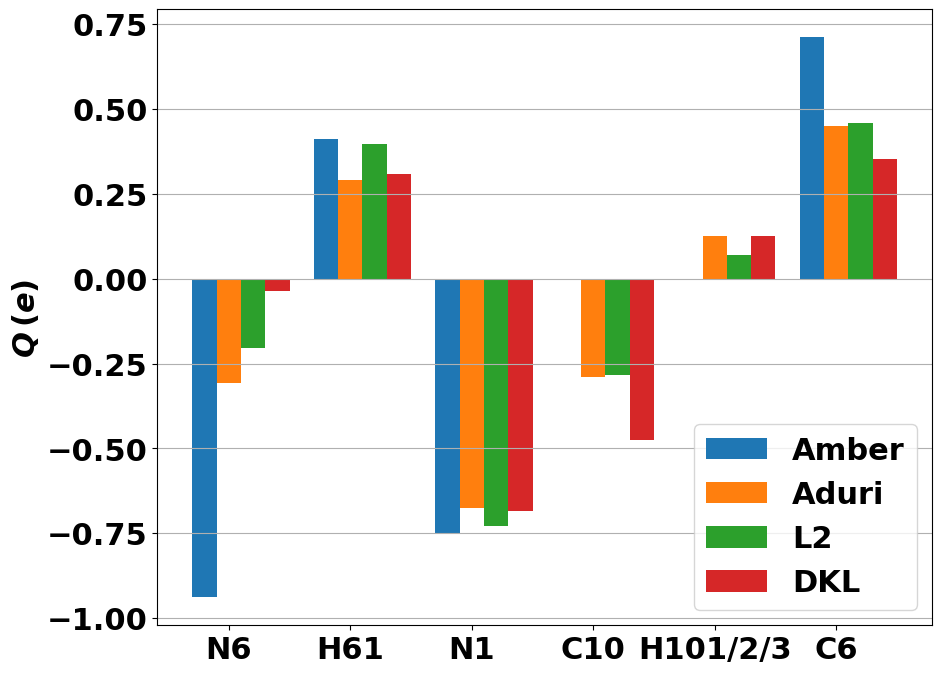

In [ ]:
font = {'weight' : 'bold', 'size' : 22}

matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 10

df = df[['Amber', 'Aduri', 'L2', 'DKL']].iloc[:-1]
df.index = [s[:-4] for s in list(df.index)]

plot_DataFrame(df)

plt.ylabel('$Q \, (e)$')
plt.gca().yaxis.grid(True)
plt.savefig('../../Figures/alch_charges.pdf', format='pdf', bbox_inches='tight')
